## Classify RNA-Seq + ATAC-Seq by Cell type

In [102]:
# import needed modules:

# general python utilities
import os
import platform
import random
import shutil
import sys
import time
import datetime
import functools
import itertools as it
import copy

# recommended Python3 version >= 3.5
print('Python version: {}'.format(platform.sys.version))

# data-science & processing tools
import numpy as np
import pandas as pd
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import h5py
import scanpy as sc
import anndata as ann

# progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm_notebook as tqdm

# plotting utilities
import seaborn as sns
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf
import tensorflow.keras as K

# required TensorFlow version >= 2.0.0
tf_version = tf.__version__
print('TensorFlow version: {}'.format(tf_version))
assert int(tf_version[0]) >= 2, "Tensorflow version must be >= 2.0"

# seed random numbers for reproducibility
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

print('\nImports Complete.')

Python version: 3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 22:05:27) 
[Clang 9.0.1 ]
TensorFlow version: 2.1.0

Imports Complete.


In [103]:
# make some fake data until real data becomes available
n_samples, n_rna_features, n_atac_features = 6000, 500, 100
rna_seq_fake = np.random.rand(n_samples, n_rna_features)
atac_seq_fake = np.random.rand(n_samples, n_atac_features)
X_np = np.concatenate([rna_seq_fake, atac_seq_fake], axis=1)
Y_np = np.array(['cell_type_A'] * 2000 + ['cell_type_B'] * 2000 + ['cell_type_C'] * 2000)

In [104]:
# make one-hot encoding of cell type classes
le = LabelEncoder()
Y_le = le.fit_transform(Y_np)
tf.one_hot(Y_le, depth=3)

<tf.Tensor: shape=(6000, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)>

In [140]:
''' Load in matrices generated after pre-processing steps '''
PATH = os.getcwd() # make sure cwd is 6_874-Multimodal-DL
OUTPUTS = os.path.join(PATH, 'Outputs')
atac_data_path = os.path.join(OUTPUTS, 'atacRaw_LowDim_svd50')
rna_data_path = os.path.join(OUTPUTS, 'rnaRaw_LowDim_pca30')
# bimodal_data_path = os.path.join(OUTPUTS, 'scAI_CellLoad_20Factor')
bim_low_data_path = os.path.join(OUTPUTS, 'scAi_CellLoad') # 2 factors

# save as pandas dataframes
atac_df = pd.read_hdf(atac_data_path)
rna_df = pd.read_hdf(rna_data_path)
# bimodal_df = pd.read_hdf(bimodal_data_path)
bi_low_df = pd.read_hdf(bim_low_data_path)

In [223]:
# merge rna and atac together if bimodal dataset not already created
bimodal_df = pd.merge(rna_df, atac_df, on=['sample', 'treatTime'], suffixes=('_rna', '_atac'))

In [224]:
bimodal_df

,sample,treatTime,0_rna,1_rna,2_rna,3_rna,4_rna,5_rna,6_rna,7_rna,...,40,41,42,43,44,45,46,47,48,49
0,sci_RNA_A_001_TCTCTCATCC,0,0.510417,5.928225,-0.037952,3.333141,4.219339,-2.630160,-0.615409,-1.955352,...,-0.219865,-0.231562,0.337380,0.989798,-0.549120,-1.325104,-0.122239,-1.658196,-0.432369,1.570464
1,sci_RNA_A_001_GACCAATGCG,0,3.000306,3.185586,-3.430007,0.491120,0.120340,1.625035,0.064617,0.429203,...,-0.870405,0.755284,-0.041358,-1.395688,1.181735,0.216738,1.692452,2.100674,-2.560527,-0.160578
2,sci_RNA_A_002_ATCTAGGTTC,0,5.106206,2.963834,-1.492047,0.171599,2.810880,1.545500,-1.419537,-0.902134,...,0.567374,-0.888025,-0.493230,0.326492,-0.125542,0.272746,0.047104,-0.223998,-0.616991,0.289083
3,sci_RNA_A_003_ACGTTGAATG,0,3.475368,5.050186,2.494665,3.177159,1.763771,4.073036,-1.079724,1.063159,...,0.995619,-1.017011,0.502295,0.181715,-0.152512,0.136581,0.448731,0.966281,-0.715115,0.232737
4,sci_RNA_A_003_CCTAAGCGGT,0,-3.759883,4.795824,-0.568844,5.767854,0.529048,0.853587,-1.837509,-1.616718,...,-0.821355,0.565135,1.437746,0.354603,-0.120906,-0.581741,-0.219004,0.254667,-0.181056,0.308072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2636,sci_RNA_E_095_ACGATAGACT,3,-1.876843,-3.717046,-0.423029,-1.293610,-0.701676,1.601468,-0.670987,0.434144,...,-0.707394,0.093768,-0.579160,1.306410,-1.453121,-1.531913,1.048622,-1.171767,-0.324598,0.114476
2637,sci_RNA_E_096_TGCCTAACTT,3,3.106059,-7.233339,1.144507,0.634749,-5.691073,1.076291,-1.273896,1.573063,...,-0.039570,-0.382012,0.170209,-0.354368,0.514323,0.143774,0.491185,-0.094987,0.275879,0.055669
2638,sci_RNA_E_096_GGCGGTTGAC,3,-2.777064,-2.984624,2.053412,1.414156,1.420331,-1.518408,-1.259496,-0.507429,...,2.874404,0.306406,-1.604938,-2.499980,-0.242752,-2.075504,-0.202921,1.751214,-2.805438,2.643512
2639,sci_RNA_E_096_CGAATCTCCT,3,-4.518046,-4.378331,-1.497701,1.266941,-0.543650,-5.178307,-2.718737,-1.898486,...,0.355951,-0.550593,-0.993096,0.761652,-1.603567,-0.098866,0.097642,1.224674,1.143904,-0.284271


In [143]:
atac_df['treatTime'].value_counts()

3    1075
1     983
0     583
Name: treatTime, dtype: int64

In [144]:
rna_df['treatTime'].value_counts()

3    1075
1     983
0     583
Name: treatTime, dtype: int64

In [145]:
bimodal_df['treatTime'].value_counts()

3    1075
1     983
0     583
Name: treatTime, dtype: int64

In [146]:
bi_low_df['treatTime'].value_counts()

3    1075
1     983
0     583
Name: treatTime, dtype: int64

In [225]:
bimodal_df

,sample,treatTime,0_rna,1_rna,2_rna,3_rna,4_rna,5_rna,6_rna,7_rna,...,40,41,42,43,44,45,46,47,48,49
0,sci_RNA_A_001_TCTCTCATCC,0,0.510417,5.928225,-0.037952,3.333141,4.219339,-2.630160,-0.615409,-1.955352,...,-0.219865,-0.231562,0.337380,0.989798,-0.549120,-1.325104,-0.122239,-1.658196,-0.432369,1.570464
1,sci_RNA_A_001_GACCAATGCG,0,3.000306,3.185586,-3.430007,0.491120,0.120340,1.625035,0.064617,0.429203,...,-0.870405,0.755284,-0.041358,-1.395688,1.181735,0.216738,1.692452,2.100674,-2.560527,-0.160578
2,sci_RNA_A_002_ATCTAGGTTC,0,5.106206,2.963834,-1.492047,0.171599,2.810880,1.545500,-1.419537,-0.902134,...,0.567374,-0.888025,-0.493230,0.326492,-0.125542,0.272746,0.047104,-0.223998,-0.616991,0.289083
3,sci_RNA_A_003_ACGTTGAATG,0,3.475368,5.050186,2.494665,3.177159,1.763771,4.073036,-1.079724,1.063159,...,0.995619,-1.017011,0.502295,0.181715,-0.152512,0.136581,0.448731,0.966281,-0.715115,0.232737
4,sci_RNA_A_003_CCTAAGCGGT,0,-3.759883,4.795824,-0.568844,5.767854,0.529048,0.853587,-1.837509,-1.616718,...,-0.821355,0.565135,1.437746,0.354603,-0.120906,-0.581741,-0.219004,0.254667,-0.181056,0.308072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2636,sci_RNA_E_095_ACGATAGACT,3,-1.876843,-3.717046,-0.423029,-1.293610,-0.701676,1.601468,-0.670987,0.434144,...,-0.707394,0.093768,-0.579160,1.306410,-1.453121,-1.531913,1.048622,-1.171767,-0.324598,0.114476
2637,sci_RNA_E_096_TGCCTAACTT,3,3.106059,-7.233339,1.144507,0.634749,-5.691073,1.076291,-1.273896,1.573063,...,-0.039570,-0.382012,0.170209,-0.354368,0.514323,0.143774,0.491185,-0.094987,0.275879,0.055669
2638,sci_RNA_E_096_GGCGGTTGAC,3,-2.777064,-2.984624,2.053412,1.414156,1.420331,-1.518408,-1.259496,-0.507429,...,2.874404,0.306406,-1.604938,-2.499980,-0.242752,-2.075504,-0.202921,1.751214,-2.805438,2.643512
2639,sci_RNA_E_096_CGAATCTCCT,3,-4.518046,-4.378331,-1.497701,1.266941,-0.543650,-5.178307,-2.718737,-1.898486,...,0.355951,-0.550593,-0.993096,0.761652,-1.603567,-0.098866,0.097642,1.224674,1.143904,-0.284271


**Observations**: 
- There are over 20,000 features, but only 3260 samples. Consider using PCA or another dimensionality reduction method before inputing into network
- This matrix is super sparse. Think about how to account for that (maybe in feature selection)
- TODO - feature selection

In [226]:
''' Get labels'''
Y_atac = atac_df['treatTime']
Y_rna = rna_df['treatTime']
Y_bimodal = bimodal_df['treatTime']
Y_bi_low = bi_low_df['treatTime']

In [227]:
''' Change to label-encoded values'''
le = LabelEncoder()
Y_atac_le = le.fit_transform(Y_atac) # note that this changes treatment time of 3 to 2, but other labels are the same
Y_rna_le = le.fit_transform(Y_rna)
Y_bimodal_le = le.fit_transform(Y_bimodal)
Y_bi_low_le = le.fit_transform(Y_bi_low)

In [228]:
''' Get feature labels '''
# get features
atac_features = atac_df.iloc[:, 2:].columns
rna_features = rna_df.iloc[:, 2:].columns
bimodal_features = bimodal_df.iloc[:, 2:].columns
bi_low_features = bi_low_df.iloc[:, 2:].columns

# get number of features
n_atac_features = len(atac_features)
n_rna_features = len(rna_features)
n_bi_features = len(bimodal_features)
n_bi_low_features = len(bi_low_features)

In [229]:
rna_features

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
      dtype='object')

In [230]:
''' Make matrices into numpy arrays'''
X_atac_np = atac_df.iloc[:, 2:].to_numpy()
X_rna_np = rna_df.iloc[:, 2:].to_numpy()
X_bimodal_np = bimodal_df.iloc[:, 2:].to_numpy()
X_bi_low_np = bi_low_df.iloc[:, 2:].to_numpy()

In [231]:
atac_df.iloc[:,1]

0       0
1       0
2       0
3       0
4       0
       ..
2636    3
2637    3
2638    3
2639    3
2640    3
Name: treatTime, Length: 2641, dtype: int64

In [235]:
''' Get training and test sets '''
# TODO - make sure these are stratified
X_train_atac, X_test_atac, Y_train_atac, Y_test_atac = train_test_split(X_atac_np, Y_atac_le, 
                                                                        test_size=0.1, random_state=0, 
                                                                        stratify=Y_atac_le)
X_train_rna, X_test_rna, Y_train_rna, Y_test_rna = train_test_split(X_rna_np, Y_rna_le, 
                                                                    test_size=0.1, random_state=0, 
                                                                    stratify=Y_rna_le)
X_train_bi, X_test_bi, Y_train_bi, Y_test_bi = train_test_split(X_bimodal_np, Y_bimodal_le, 
                                                                test_size=0.1, random_state=0, 
                                                                stratify=Y_bimodal_le)
X_train_bi_low, X_test_bi_low, Y_train_bi_low, Y_test_bi_low = train_test_split(X_bi_low_np, Y_bi_low_le, 
                                                                                test_size=0.1, random_state=0, 
                                                                                stratify=Y_bi_low_le)


In [236]:
''' Make Y labels one-hot '''
# training sets
Y_atac_train = tf.one_hot(Y_train_atac, depth=3)
Y_rna_train = tf.one_hot(Y_train_rna, depth=3)
Y_bimodal_train = tf.one_hot(Y_train_bi, depth=3)
Y_bi_low_train = tf.one_hot(Y_train_bi_low, depth=3)


# test sets
Y_atac_test = tf.one_hot(Y_test_atac, depth=3)
Y_rna_test = tf.one_hot(Y_test_rna, depth=3)
Y_bimodal_test = tf.one_hot(Y_test_bi, depth=3)
Y_bi_low_test = tf.one_hot(Y_test_bi_low, depth=3)

In [237]:
''' Make sure np arrays are float32 before converting to tensors '''
X_train_atac = np.asarray(X_train_atac).astype(np.float32)
X_train_rna = np.asarray(X_train_rna).astype(np.float32)
X_train_bi = np.asarray(X_train_bi).astype(np.float32)
X_train_bi_low = np.asarray(X_train_bi_low).astype(np.float32)

X_test_atac = np.asarray(X_test_atac).astype(np.float32)
X_test_rna = np.asarray(X_test_rna).astype(np.float32)
X_test_bi = np.asarray(X_test_bi).astype(np.float32)
X_test_bi_low = np.asarray(X_test_bi_low).astype(np.float32)

In [238]:
X_train_atac.shape, X_train_rna.shape, X_train_bi.shape, X_train_bi_low.shape

((2376, 50), (2376, 30), (2376, 80), (2376, 2))

In [239]:
''' Make matrices into TF tensors'''
# training sets
X_atac_train = tf.convert_to_tensor(X_train_atac)
X_rna_train = tf.convert_to_tensor(X_train_rna)
X_bimodal_train = tf.convert_to_tensor(X_train_bi)
X_bi_low_train = tf.convert_to_tensor(X_train_bi_low)


# test sets
X_atac_test = tf.convert_to_tensor(X_test_atac)
X_rna_test = tf.convert_to_tensor(X_test_rna)
X_bimodal_test = tf.convert_to_tensor(X_test_bi)
X_bi_low_test = tf.convert_to_tensor(X_test_bi_low)

In [241]:
''' Define architecture '''
HIDDEN_LAYER_DIMS = [500, 500, 2000]
OUTPUT_DIM = 3

def nn_model(n_features, dropout_rate, l2_lambda):
    """
    Returns a tf.keras.Model for cell-type classification with the specifications 
    listed above.
    
    Arguments:
      n_features: the number of features of the datapoints used
        as input to the model (used to determine the input shape)
      dropout_rate: the dropout rate of the dropout layers
      l2_lambda: the weight of the L2 regularization penalty on the
        weights (but not the biases) of the model
    
    Returns:
      model: a tf.keras.Model for tSNE with the specifications
        listed above
    """
    model = K.Sequential()
    
    
    l2_reg = tf.keras.regularizers.l2(l=l2_lambda)
    ######################## BEGIN YOUR ANSWER ########################
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[0], batch_input_shape=(None, n_features), 
                                    activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[1], batch_input_shape=(None, n_features),
                                   activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[2], batch_input_shape=(None, n_features),
                                   activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(OUTPUT_DIM, batch_input_shape=(None, n_features),
                                   activation=tf.nn.softmax, kernel_regularizer=l2_reg))
    
    ######################### END YOUR ANSWER #########################
    
    return model

In [270]:
''' Define architecture '''
HIDDEN_LAYER_DIMS = [50, 50, 200]
OUTPUT_DIM = 3

def nn_model_factor(n_features, dropout_rate, l2_lambda):
    """
    Returns a tf.keras.Model for cell-type classification with the specifications 
    listed above.
    
    Arguments:
      n_features: the number of features of the datapoints used
        as input to the model (used to determine the input shape)
      dropout_rate: the dropout rate of the dropout layers
      l2_lambda: the weight of the L2 regularization penalty on the
        weights (but not the biases) of the model
    
    Returns:
      model: a tf.keras.Model for tSNE with the specifications
        listed above
    """
    model = K.Sequential()
    
    
    l2_reg = tf.keras.regularizers.l2(l=l2_lambda)
    ######################## BEGIN YOUR ANSWER ########################
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[0], batch_input_shape=(None, n_features), 
                                    activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[1], batch_input_shape=(None, n_features),
                                   activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[2], batch_input_shape=(None, n_features),
                                   activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(OUTPUT_DIM, batch_input_shape=(None, n_features),
                                   activation=tf.nn.softmax, kernel_regularizer=l2_reg))
    
    ######################### END YOUR ANSWER #########################
    
    return model

In [275]:
''' Give summary of architecture '''
n_features = len(bimodal_features)
model = nn_model_factor(n_features, dropout_rate=0.2, l2_lambda=0.1)
model.summary()

Model: "sequential_195"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_780 (Dense)            (None, 50)                4050      
_________________________________________________________________
dropout_585 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_781 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_586 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_782 (Dense)            (None, 200)               10200     
_________________________________________________________________
dropout_587 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_783 (Dense)            (None, 3)              

In [276]:
def sample_shuffle_data(arrays, n_samples=None):
    """subsamples examples from a list of datasets
    
    samples `n_samples` without replacement from along the first dimension
    of each array in `arrays`. The same first-dimension slices are 
    selected for each array in `arrays`.
    
    Arguments:
      arrays: the arrays to be sliced, all must have the same size along 
        their first dimension.
      n_samples: (None) the number of samples to be selected, `n_samples` must 
        be less than or equal to the length of the arrays. If n_samples it not
        passed or is `None`. Then each array in `arrays` will be 
        shuffled in the same way and returned.
      
    Returns:
      sampled: a `tuple` of len the same as `len(arrays)` where each
        element is an array of len `n_samples`
    """
    batch_len = arrays[0].shape[0]
    n_samples = batch_len if n_samples is None else n_samples

    err_msg = 'all arrays must have the same size along their first dimension'
    assert all(batch_len == x.shape[0] for x in arrays), err_msg 
    err_msg = 'n cannot be greater then the length of the arrays'
    assert n_samples <= batch_len, err_msg

    sampling_idxs = tf.random.shuffle(tf.range(batch_len))[:n_samples]
    sampled = tuple(tf.gather(x, sampling_idxs, axis=0) for x in arrays)
    
    return sampled

In [277]:
''' Train step '''
def train_step(model, loss, optimizer, x_batch, y_batch):
    """
    Performs one training step on a model given a loss, optimizer, inputs,
    and labels.
    
    Arguments:
      model: the model on which the pass will be performed
      loss: the loss function to be evaluated, from which the gradients will be
        computed
      optimizer: a `tf.optimizers` object defining the optimization scheme
      x_batch: model training inputs
      y_batch: model training labels
      
    Returns:
      loss_value: the computed loss for the forward training pass
    """
#     print('X_batch : {} \n y_batch : {}'.format(x_batch, y_batch))
    with tf.GradientTape() as tape:
#         print(f'x_batch: {x_batch}')
#         print(f'y_batch: {y_batch}')

        y_batch_pred = model(x_batch, training=True)
        loss_value = loss(y_batch, y_batch_pred)
#         print(f"model losses type: {model.losses}")
        loss_value += sum(model.losses)
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return loss_value

In [278]:
''' Training Loop '''
def training(x_train, y_train, x_val, y_val, hyperparam_config, num_epochs, batch_size,
             save_model=True, model_dir='models/best_model'):  
    
    """
    Train a fully-connected network to classify rna_seq + atac-seq by cell type
    
    Arguments:
      x_train: input training set
      y_train: label training set
      x_val: input validation set
      y_val: label validation set
      hyperparam_config: a dictionary that stores a hyperparameter configuration,
                         including:
                           - "dropout_rate": dropout rate (1 - keep probability),
                           - "l2": coefficient lambda for L2 regularization,
                           - "lr": learning rate for RMSProp optimizer
      num_epochs: number of epochs to train
      batch_size: training mini-batch size (must be same as the batch size for pairwise P calculation)
      save_model: whether or not to save the best model based on the validation loss
      model_dir: location where model will be saved
    
    Returns:
      best_loss: best validation loss
      best_kl_div: validation KL loss from the epoch that has best validation loss
    """
    
    ################################################################################
    # Make sure to wrap train_step with tf.function to speed up training!
    train_fn = tf.function(train_step)
#     train_fn = train_step
    ################################################################################ 
    
    ######################## BEGIN YOUR ANSWER ########################
    # get num_batches
    num_samples, num_features = x_train.shape
    num_batches = np.floor(num_samples) // batch_size
    
    # initalize model, loss, and optimizers
    dropout_rate = hyperparam_config['dropout_rate']
    l2_lambda = hyperparam_config['l2_lambda']
    lr = hyperparam_config['lr']
    model = nn_model_factor(n_features=num_features, dropout_rate=dropout_rate, l2_lambda=l2_lambda)
    loss_fn = tf.keras.losses.CategoricalCrossentropy() # todo - make sure this is correct
    optimizer = K.optimizers.SGD(learning_rate=lr)  #TODO - double check this optimizer

    
    # Get initial loss for comparison 
    print('getting initial loss')
    best_loss = loss_fn(y_val, model(x_val))
    
    # init progress bars
    epoch_pbar = tqdm(total=num_epochs, desc="Training Epochs")
    batch_pbar = tqdm(desc="Training Steps")
    
    
    n = x_train.shape[0]
    # for each epoch   
    # start training loop 
    for epoch in range(num_epochs):
        # shuffle data
        if epoch >= 1: x_train, y_train = sample_shuffle_data([x_train, y_train], num_samples)
        
        batch_pbar.reset(num_batches)
        for step in range(int(num_batches)):
            # getting indices of batches to train on
            range_begin = (step * batch_size) % (x_train.shape[0] - batch_size) #taking mod to prevent ix errors
            range_end = range_begin + batch_size
            batch_x = x_train[range_begin:range_end, :]
            batch_y = y_train[range_begin:range_end, :]
            epoch_loss = train_fn(model, loss_fn, optimizer,
                                 batch_x, batch_y)
  
            
            batch_pbar.update()
    
        # compute and print loss on validation data
        val_loss = loss_fn(y_val, model(x_val)) #note - don't need reg_coeff defined because already defined using functools.partial
        
        if epoch%5 ==0:
            tf.print("epoch: {:02d}, loss: {:5.3f}".format(epoch, val_loss))
        
        if val_loss < best_loss:
            best_loss = val_loss
            if save_model:
                # if directory hasn't been created, create it
                if not os.path.isdir('models'):
                    !mkdir -p models
                # if model has already been saved, remove folder and save again
                if os.path.isdir(model_dir):
                    shutil.rmtree(model_dir)
                # make directory again and save
#                 !mkdir -p models/best_loss
                model.save(model_dir)
        batch_pbar.refresh()
        epoch_pbar.update()
            
                
    ######################### END YOUR ANSWER #########################
    
    
    return best_loss


In [279]:
''' Get useful parameters for defining architecture '''
X_shape = tf.shape(X_bimodal_train)
assert len(X_shape) == 2, f'Order of input tensor shoud be 2 but is {len(X_shape)}'
num_cells, num_features = X_shape
dropout_rate = 0.1
l2_lambda = 1e-6
learning_rate = 0.001

In [280]:
Y_atac_test;

In [281]:
n_epochs = 50

In [282]:
''' This cell will train the model on a given set of hyperparameters. This code is repeated later'''
''' Train model using ATAC-seq as features'''
# define hyperparameters
run_cell=False
if run_cell:
    hyperparams_atac = {'dropout_rate':0.1, 'lr': 0.001, 'l2_lambda': l2_lambda}


    training(X_atac_train, Y_atac_train, X_atac_test, Y_atac_test, 
             hyperparam_config=hyperparams_atac,
            num_epochs=n_epochs,
            batch_size=100,
            save_model=True,
            model_dir=f'models/atac_only_model_{n_epochs}_epochs')

    ''' Train model using RNA-seq as features'''
    # define hyperparameters
    hyperparams_rna = {'dropout_rate':0.1, 'lr': 0.001, 'l2_lambda': l2_lambda}

    training(X_rna_train, Y_rna_train, X_rna_test, Y_rna_test, 
             hyperparam_config=hyperparams_rna,
            num_epochs=50,
            batch_size=100,
            save_model=True,
            model_dir=f'models/rna_only_model_{n_epochs}_epochs')

    ''' Train model using both ATAC and RNA as features'''
    # define hyperparameters
    hyperparams_bimodal = {'dropout_rate':0.1, 'lr': 0.001, 'l2_lambda': l2_lambda}

    training(X_bimodal_train, Y_bimodal_train, X_bimodal_test, Y_bimodal_test, 
             hyperparam_config=hyperparams_bimodal,
            num_epochs=50,
            batch_size=100,
            save_model=True,
            model_dir=f'models/bimodal_model_{n_epochs}_epochs')

## Hyperparameter tuning

In [283]:
''' Hyperparameter search using validation set'''
def grid_search(x_train, y_train, dropout_rates, l2_lambdas, learning_rates, num_epochs=40, batch_size=300):
    """
    Perform grid search for the best tSNE hyperparameters
    
    Arguments:
      x_train: input training set
      y_train: label training set
      dropout_rates: dropout rates to try
      l2_lambdas: L2 lambda coefficients to try
      learning_rates: learning rates to try
      num_epochs: number of epochs to train
      batch_size: training mini-batch size
    
    Returns:
      losses: list losses for configurations tested where
        losses[i] = [dropout_rate, l2_lambda, learning_rate, best_loss, best_kl_divgergence]
    """
    losses = []
    
    pbar = tqdm(total = len(dropout_rates) * len(l2_lambdas) * len(learning_rates))
    for dropout_rate in dropout_rates:
        for l2_lambda in l2_lambdas:
            for learning_rate in learning_rates:
                print("training with dropout:{} l2:{} lr:{}".format(dropout_rate,l2_lambda,learning_rate))
                # DO NOT shuffle your validation/train set because the pairwise label are calculated by batch
                # Use the last batch in train set as the validation set
                subset_x_train, subset_y_train=(x_train[0:-batch_size],y_train[0:-batch_size])
                subset_x_val, subset_y_val = (x_train[-batch_size:],y_train[-batch_size:])
                hyperparam_config = {'dropout_rate': dropout_rate,
                                     'l2_lambda': l2_lambda,
                                     'lr': learning_rate}

                best_loss = training(subset_x_train, subset_y_train,
                                     subset_x_val, subset_y_val,
                                     hyperparam_config,
                                     num_epochs,
                                     batch_size,
                                     save_model=False)

                losses.append([dropout_rate, l2_lambda, learning_rate, best_loss])
                pbar.update(1)
    pbar.close()
    return losses


In [284]:
dropout_rates = [0.5, 0.2, 0.1]
l2_lambdas = [1e-03, 1e-06]
learning_rates = [0.1, 0.01, 1e-4]
NUM_EPOCHS = 20
BATCH_SIZE = 64

In [181]:
''' GRID-SEARCH for ATAC-seq as input'''
atac_param_result = grid_search(X_atac_train, Y_atac_train, dropout_rates, l2_lambdas, learning_rates, NUM_EPOCHS, BATCH_SIZE)

training with dropout:0.5 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 1.071
epoch: 05, loss: 0.979
epoch: 10, loss: 0.918
epoch: 15, loss: 1.130
training with dropout:0.5 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.074
epoch: 05, loss: 1.067
epoch: 10, loss: 1.043
epoch: 15, loss: 0.998
training with dropout:0.5 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.127
epoch: 05, loss: 1.121
epoch: 10, loss: 1.117
epoch: 15, loss: 1.114
training with dropout:0.5 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 1.080
epoch: 05, loss: 0.977
epoch: 10, loss: 1.059
epoch: 15, loss: 0.866
training with dropout:0.5 l2:1e-06 lr:0.01
getting initial loss


epoch: 00, loss: 1.075
epoch: 05, loss: 1.044
epoch: 10, loss: 1.004
epoch: 15, loss: 0.964
training with dropout:0.5 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.091
epoch: 05, loss: 1.087
epoch: 10, loss: 1.085
epoch: 15, loss: 1.083
training with dropout:0.2 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 1.062
epoch: 05, loss: 0.955
epoch: 10, loss: 1.390
epoch: 15, loss: 1.216
training with dropout:0.2 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.077
epoch: 05, loss: 1.001
epoch: 10, loss: 0.911
epoch: 15, loss: 0.935
training with dropout:0.2 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.103
epoch: 05, loss: 1.100
epoch: 10, loss: 1.097
epoch: 15, loss: 1.095
training with dropout:0.2 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 1.032
epoch: 05, loss: 1.054
epoch: 10, loss: 1.501
epoch: 15, loss: 1.764
training with dropout:0.2 l2:1e-06 lr:0.01
getting initial loss


epoch: 00, loss: 1.083
epoch: 05, loss: 1.024
epoch: 10, loss: 0.930
epoch: 15, loss: 0.992
training with dropout:0.2 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.141
epoch: 05, loss: 1.127
epoch: 10, loss: 1.118
epoch: 15, loss: 1.111
training with dropout:0.1 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 1.016
epoch: 05, loss: 1.161
epoch: 10, loss: 1.313
epoch: 15, loss: 1.267
training with dropout:0.1 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.076
epoch: 05, loss: 1.009
epoch: 10, loss: 0.942
epoch: 15, loss: 0.936
training with dropout:0.1 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.098
epoch: 05, loss: 1.098
epoch: 10, loss: 1.097
epoch: 15, loss: 1.097
training with dropout:0.1 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 1.062
epoch: 05, loss: 1.322
epoch: 10, loss: 1.600
epoch: 15, loss: 1.601
training with dropout:0.1 l2:1e-06 lr:0.01
getting initial loss


epoch: 00, loss: 1.076
epoch: 05, loss: 0.972
epoch: 10, loss: 0.892
epoch: 15, loss: 0.930
training with dropout:0.1 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.095
epoch: 05, loss: 1.092
epoch: 10, loss: 1.089
epoch: 15, loss: 1.087



In [182]:
''' GRID-SEARCH with RNA-seq as input'''
dropout_rates = [0.5, 0.2, 0.1]
l2_lambdas = [1e-03, 1e-06]
learning_rates = [0.1, 0.01, 1e-4]
rna_param_result = grid_search(X_rna_train, Y_rna_train, dropout_rates, l2_lambdas, learning_rates, NUM_EPOCHS, BATCH_SIZE)

training with dropout:0.5 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 0.971
epoch: 05, loss: 0.512
epoch: 10, loss: 0.388
epoch: 15, loss: 0.438
training with dropout:0.5 l2:0.001 lr:0.01

getting initial loss


epoch: 00, loss: 1.096
epoch: 05, loss: 1.043
epoch: 10, loss: 0.933
epoch: 15, loss: 0.776
training with dropout:0.5 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.323
epoch: 05, loss: 1.184
epoch: 10, loss: 1.138
epoch: 15, loss: 1.113
training with dropout:0.5 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 1.017
epoch: 05, loss: 0.548
epoch: 10, loss: 0.475
epoch: 15, loss: 0.411
training with dropout:0.5 l2:1e-06 lr:0.01
getting initial loss


epoch: 00, loss: 1.061
epoch: 05, loss: 1.006
epoch: 10, loss: 0.900
epoch: 15, loss: 0.781
training with dropout:0.5 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.169
epoch: 05, loss: 1.131
epoch: 10, loss: 1.114
epoch: 15, loss: 1.103
training with dropout:0.2 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 0.876
epoch: 05, loss: 0.273
epoch: 10, loss: 0.358
epoch: 15, loss: 0.582
training with dropout:0.2 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.040
epoch: 05, loss: 0.676
epoch: 10, loss: 0.478
epoch: 15, loss: 0.373
training with dropout:0.2 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.215
epoch: 05, loss: 1.166
epoch: 10, loss: 1.146
epoch: 15, loss: 1.137
training with dropout:0.2 l2:1e-06 lr:0.1

getting initial loss


epoch: 00, loss: 1.001
epoch: 05, loss: 0.389
epoch: 10, loss: 0.485
epoch: 15, loss: 0.449
training with dropout:0.2 l2:1e-06 lr:0.01
getting initial loss


epoch: 00, loss: 1.017
epoch: 05, loss: 0.561
epoch: 10, loss: 0.396
epoch: 15, loss: 0.325
training with dropout:0.2 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.052
epoch: 05, loss: 1.037
epoch: 10, loss: 1.029
epoch: 15, loss: 1.024
training with dropout:0.1 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 1.037
epoch: 05, loss: 0.931
epoch: 10, loss: 0.434
epoch: 15, loss: 0.757
training with dropout:0.1 l2:0.001 lr:0.01

getting initial loss


epoch: 00, loss: 0.969
epoch: 05, loss: 0.518
epoch: 10, loss: 0.343
epoch: 15, loss: 0.280
training with dropout:0.1 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.330
epoch: 05, loss: 1.200
epoch: 10, loss: 1.151
epoch: 15, loss: 1.129
training with dropout:0.1 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 0.760
epoch: 05, loss: 0.501
epoch: 10, loss: 0.344
epoch: 15, loss: 0.499
training with dropout:0.1 l2:1e-06 lr:0.01
getting initial loss


epoch: 00, loss: 1.002
epoch: 05, loss: 0.438
epoch: 10, loss: 0.280
epoch: 15, loss: 0.237
training with dropout:0.1 l2:1e-06 lr:0.0001

getting initial loss


epoch: 00, loss: 1.175
epoch: 05, loss: 1.128
epoch: 10, loss: 1.102
epoch: 15, loss: 1.087



In [253]:
''' GRID-SEARCH with bimodal input '''
dropout_rates = [0.5, 0.2, 0.1]
l2_lambdas = [1e-03, 1e-06]
learning_rates = [0.1, 0.01, 1e-4]
bimodal_param_result = grid_search(X_bimodal_train, Y_bimodal_train, dropout_rates, l2_lambdas, learning_rates, NUM_EPOCHS, BATCH_SIZE)

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Steps: 0it [00:00, ?it/s]

Training Steps:   0%|          | 0/36.0 [00:00<?, ?it/s]

training with dropout:0.5 l2:0.001 lr:0.1
getting initial loss




Training Steps:   3%|▎         | 1/36.0 [00:00<00:13,  2.61it/s]

epoch: 00, loss: 0.943




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]
Training Epochs:   5%|▌         | 1/20 [00:00<00:07,  2.39it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]
Training Epochs:  25%|██▌       | 5/20 [00:00<00:04,  3.31it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

epoch: 05, loss: 0.331




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]
Training Epochs:  45%|████▌     | 9/20 [00:00<00:02,  4.55it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

epoch: 10, loss: 0.364




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]
Training Epochs:  65%|██████▌   | 13/20 [00:00<00:01,  6.17it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

epoch: 15, loss: 0.379




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]
Training Epochs:  85%|████████▌ | 17/20 [00:00<00:00,  8.21it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:13,  2.61it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  2.61it/s]

Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 20.85it/s] 
Training Steps: 100%|██████████| 36/36.0 [00:00<00:00, 987.46it/s]
Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]



training with dropout:0.5 l2:0.001 lr:0.01
getting initial loss


Training Steps: 0it [00:00, ?it/s]

Training Steps:   0%|          | 0/36.0 [00:00<?, ?it/s]

Training Steps:   3%|▎         | 1/36.0 [00:00<00:10,  3.39it/s]

epoch: 00, loss: 1.071




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]
Training Epochs:   5%|▌         | 1/20 [00:00<00:06,  3.05it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]
Training Epochs:  25%|██▌       | 5/20 [00:00<00:03,  4.19it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

epoch: 05, loss: 1.027




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]
Training Epochs:  45%|████▌     | 9/20 [00:00<00:01,  5.71it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

epoch: 10, loss: 0.928




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]
Training Epochs:  65%|██████▌   | 13/20 [00:00<00:00,  7.65it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

epoch: 15, loss: 0.832




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]
Training Epochs:  85%|████████▌ | 17/20 [00:00<00:00, 10.02it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.39it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.39it/s]

Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 23.01it/s] 
Training Steps: 100%|██████████| 36/36.0 [00:00<00:00, 981.89it/s]
Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

training with dropout:0.5 l2:0.001 lr:0.0001
getting initial loss




Training Steps: 0it [00:00, ?it/s]

Training Steps:   0%|          | 0/36.0 [00:00<?, ?it/s]

Training Steps:   3%|▎         | 1/36.0 [00:00<00:09,  3.70it/s]

epoch: 00, loss: 1.368




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]
Training Epochs:   5%|▌         | 1/20 [00:00<00:05,  3.24it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]
Training Epochs:  25%|██▌       | 5/20 [00:00<00:03,  4.44it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

epoch: 05, loss: 1.300




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]
Training Epochs:  45%|████▌     | 9/20 [00:00<00:01,  5.96it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

epoch: 10, loss: 1.247




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]
Training Epochs:  65%|██████▌   | 13/20 [00:00<00:00,  7.91it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

epoch: 15, loss: 1.206




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]
Training Epochs:  85%|████████▌ | 17/20 [00:00<00:00, 10.29it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.70it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.70it/s]

Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 22.22it/s] 
Training Steps: 100%|██████████| 36/36.0 [00:00<00:00, 915.78it/s]
 17%|█▋        | 3/18 [00:03<00:15,  1.02s/it]

training with dropout:0.5 l2:1e-06 lr:0.1



Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Steps: 0it [00:00, ?it/s]

Training Steps:   0%|          | 0/36.0 [00:00<?, ?it/s]

getting initial loss




Training Steps:   3%|▎         | 1/36.0 [00:00<00:10,  3.28it/s]

epoch: 00, loss: 0.832




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]
Training Epochs:   5%|▌         | 1/20 [00:00<00:06,  2.92it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]
Training Epochs:  25%|██▌       | 5/20 [00:00<00:03,  4.01it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

epoch: 05, loss: 0.506




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]
Training Epochs:  45%|████▌     | 9/20 [00:00<00:02,  5.46it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

epoch: 10, loss: 0.508




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]
Training Epochs:  65%|██████▌   | 13/20 [00:00<00:00,  7.32it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

epoch: 15, loss: 0.448




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]
Training Epochs:  85%|████████▌ | 17/20 [00:00<00:00,  9.65it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.28it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.28it/s]

Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 22.40it/s] 
Training Steps: 100%|██████████| 36/36.0 [00:00<00:00, 994.70it/s]
Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]



training with dropout:0.5 l2:1e-06 lr:0.01
getting initial loss


Training Steps: 0it [00:00, ?it/s]

Training Steps:   0%|          | 0/36.0 [00:00<?, ?it/s]

Training Steps:   3%|▎         | 1/36.0 [00:00<00:11,  3.14it/s]

epoch: 00, loss: 1.067




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]
Training Epochs:   5%|▌         | 1/20 [00:00<00:06,  2.86it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]
Training Epochs:  20%|██        | 4/20 [00:00<00:04,  3.91it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

epoch: 05, loss: 1.054




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]
Training Epochs:  40%|████      | 8/20 [00:00<00:02,  5.30it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

epoch: 10, loss: 1.010




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]
Training Epochs:  60%|██████    | 12/20 [00:00<00:01,  7.12it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

epoch: 15, loss: 0.868




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]
Training Epochs:  80%|████████  | 16/20 [00:00<00:00,  9.34it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.14it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.14it/s]
Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 12.06it/s]

Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 21.44it/s] 
Training Steps: 100%|██████████| 36/36.0 [00:00<00:00, 955.67it/s]
Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Steps: 0it [00:00, ?it/s]

Training Steps:   0%|          | 0/36.0

training with dropout:0.5 l2:1e-06 lr:0.0001
getting initial loss




Training Steps:   3%|▎         | 1/36.0 [00:00<00:10,  3.42it/s]

epoch: 00, loss: 1.301




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]
Training Epochs:   5%|▌         | 1/20 [00:00<00:06,  3.09it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]
Training Epochs:  25%|██▌       | 5/20 [00:00<00:03,  4.24it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

epoch: 05, loss: 1.211




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]
Training Epochs:  45%|████▌     | 9/20 [00:00<00:01,  5.76it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

epoch: 10, loss: 1.158




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]
Training Epochs:  65%|██████▌   | 13/20 [00:00<00:00,  7.67it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

epoch: 15, loss: 1.126




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]
Training Epochs:  85%|████████▌ | 17/20 [00:00<00:00, 10.02it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.42it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.42it/s]

Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 22.42it/s] 
Training Steps: 100%|██████████| 36/36.0 [00:00<00:00, 937.09it/s]
 33%|███▎      | 6/18 [00:05<00:11,  1.00it/s]

training with dropout:0.2 l2:0.001 lr:0.1



Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Steps: 0it [00:00, ?it/s]

Training Steps:   0%|          | 0/36.0 [00:00<?, ?it/s]

getting initial loss




Training Steps:   3%|▎         | 1/36.0 [00:00<00:10,  3.44it/s]

epoch: 00, loss: 0.492




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]
Training Epochs:   5%|▌         | 1/20 [00:00<00:06,  3.11it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]
Training Epochs:  25%|██▌       | 5/20 [00:00<00:03,  4.27it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

epoch: 05, loss: 0.251




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]
Training Epochs:  45%|████▌     | 9/20 [00:00<00:01,  5.77it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

epoch: 10, loss: 0.245




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]
Training Epochs:  65%|██████▌   | 13/20 [00:00<00:00,  7.66it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

epoch: 15, loss: 0.263




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]
Training Epochs:  85%|████████▌ | 17/20 [00:00<00:00, 10.03it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]

Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 22.36it/s] 
Training Steps: 100%|██████████| 36/36.0 [00:00<00:00, 1031.63it/s]
Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Steps: 0it [00:00, ?it/s]

Training Steps:   0%|          | 0/36.0 [00:00<?, ?it/s]

training with dropout:0.2 l2:0.001 lr:0.01
getting initial loss




Training Steps:   3%|▎         | 1/36.0 [00:00<00:10,  3.38it/s]

epoch: 00, loss: 0.820




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]
Training Epochs:   5%|▌         | 1/20 [00:00<00:06,  3.07it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]
Training Epochs:  25%|██▌       | 5/20 [00:00<00:03,  4.22it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

epoch: 05, loss: 0.457




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]
Training Epochs:  45%|████▌     | 9/20 [00:00<00:01,  5.73it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

epoch: 10, loss: 0.340




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]
Training Epochs:  65%|██████▌   | 13/20 [00:00<00:00,  7.67it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

epoch: 15, loss: 0.276




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]
Training Epochs:  85%|████████▌ | 17/20 [00:00<00:00, 10.07it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.38it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.38it/s]

Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 23.02it/s] 
Training Steps: 100%|██████████| 36/36.0 [00:00<00:00, 978.33it/s]
Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Steps: 0it [00:00, ?it/s]

Training Steps:   0%|          | 0/36.0 [00:00<?, ?it/s]

training with dropout:0.2 l2:0.001 lr:0.0001
getting initial loss




Training Steps:   3%|▎         | 1/36.0 [00:00<00:10,  3.46it/s]

epoch: 00, loss: 1.428




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]
Training Epochs:   5%|▌         | 1/20 [00:00<00:06,  3.14it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]
Training Epochs:  25%|██▌       | 5/20 [00:00<00:03,  4.33it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

epoch: 05, loss: 1.248




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]
Training Epochs:  45%|████▌     | 9/20 [00:00<00:01,  5.85it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

epoch: 10, loss: 1.161




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]
Training Epochs:  65%|██████▌   | 13/20 [00:00<00:00,  7.79it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

epoch: 15, loss: 1.113




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]
Training Epochs:  85%|████████▌ | 17/20 [00:00<00:00, 10.20it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.46it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.46it/s]

Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 22.99it/s] 
Training Steps: 100%|██████████| 36/36.0 [00:00<00:00, 1006.15it/s]
Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Steps: 0it [00:00, ?it/s]

Training Steps:   0%|          | 0/36.0 [00:00<?, ?it/s]

training with dropout:0.2 l2:1e-06 lr:0.1
getting initial loss




Training Steps:   3%|▎         | 1/36.0 [00:00<00:09,  3.83it/s]

epoch: 00, loss: 0.428




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]
Training Epochs:   5%|▌         | 1/20 [00:00<00:05,  3.41it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]
Training Epochs:  25%|██▌       | 5/20 [00:00<00:03,  4.69it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

epoch: 05, loss: 0.276




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]
Training Epochs:  45%|████▌     | 9/20 [00:00<00:01,  6.31it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

epoch: 10, loss: 0.369




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]
Training Epochs:  65%|██████▌   | 13/20 [00:00<00:00,  8.31it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

epoch: 15, loss: 0.329




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]
Training Epochs:  85%|████████▌ | 17/20 [00:00<00:00, 10.72it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.83it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.83it/s]

Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 22.99it/s] 
Training Steps: 100%|██████████| 36/36.0 [00:00<00:00, 966.13it/s]
 56%|█████▌    | 10/18 [00:09<00:07,  1.04it/s]

training with dropout:0.2 l2:1e-06 lr:0.01
getting initial loss



Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Steps: 0it [00:00, ?it/s]

Training Steps:   0%|          | 0/36.0 [00:00<?, ?it/s]

Training Steps:   3%|▎         | 1/36.0 [00:00<00:09,  3.55it/s]

epoch: 00, loss: 1.020




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]
Training Epochs:   5%|▌         | 1/20 [00:00<00:05,  3.18it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]
Training Epochs:  25%|██▌       | 5/20 [00:00<00:03,  4.38it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

epoch: 05, loss: 0.579




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]
Training Epochs:  45%|████▌     | 9/20 [00:00<00:01,  5.95it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

epoch: 10, loss: 0.408




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]
Training Epochs:  65%|██████▌   | 13/20 [00:00<00:00,  7.92it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

epoch: 15, loss: 0.331




Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]
Training Epochs:  85%|████████▌ | 17/20 [00:00<00:00, 10.31it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]

Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.55it/s] 

Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.55it/s]
 61%|██████    | 11/18 [00:10<00:06,  1.05it/s]00:00, 12.79it/s]

training with dropout:0.2 l2:1e-06 lr:0.0001





Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]



Training Steps: 0it [00:00, ?it/s]



Training Steps:   0%|          | 0/36.0 [00:00<?, ?it/s]

getting initial loss






Training Steps:   3%|▎         | 1/36.0 [00:00<00:09,  3.63it/s]

epoch: 00, loss: 1.225






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]


Training Epochs:   5%|▌         | 1/20 [00:00<00:05,  3.24it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]


Training Epochs:  25%|██▌       | 5/20 [00:00<00:03,  4.46it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 

epoch: 05, loss: 1.159






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]


Training Epochs:  45%|████▌     | 9/20 [00:00<00:01,  6.05it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 

epoch: 10, loss: 1.116






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]


Training Epochs:  65%|██████▌   | 13/20 [00:00<00:00,  8.04it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 

epoch: 15, loss: 1.086






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]


Training Epochs:  85%|████████▌ | 17/20 [00:00<00:00, 10.46it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.63it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.63it/s]



Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 23.52it/s] 
Training Steps: 100%|██████████| 36/36.0 [00:00<00:00, 970.35it/s]
 67%|██████▋   | 12/18 [00:11<00:05,  1.05it/s]


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]



Training Steps: 0it [00:00, ?it/s]



Training Steps:   0%|       

training with dropout:0.1 l2:0.001 lr:0.1
getting initial loss






Training Steps:   3%|▎         | 1/36.0 [00:00<00:09,  3.78it/s]

epoch: 00, loss: 0.331






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]


Training Epochs:   5%|▌         | 1/20 [00:00<00:05,  3.36it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]


Training Epochs:  25%|██▌       | 5/20 [00:00<00:03,  4.62it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 

epoch: 05, loss: 0.343






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]


Training Epochs:  45%|████▌     | 9/20 [00:00<00:01,  6.26it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 

epoch: 10, loss: 0.331






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]


Training Epochs:  65%|██████▌   | 13/20 [00:00<00:00,  8.32it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 

epoch: 15, loss: 0.333






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]


Training Epochs:  85%|████████▌ | 17/20 [00:00<00:00, 10.70it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.78it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.78it/s]



Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 23.60it/s] 
Training Steps: 100%|██████████| 36/36.0 [00:00<00:00, 908.29it/s]
 72%|███████▏  | 13/18 [00:12<00:04,  1.06it/s]




training with dropout:0.1 l2:0.001 lr:0.01
getting initial loss


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]



Training Steps: 0it [00:00, ?it/s]



Training Steps:   0%|          | 0/36.0 [00:00<?, ?it/s]



Training Steps:   3%|▎         | 1/36.0 [00:00<00:10,  3.44it/s]

epoch: 00, loss: 0.960






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]


Training Epochs:   5%|▌         | 1/20 [00:00<00:06,  3.12it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]


Training Epochs:  25%|██▌       | 5/20 [00:00<00:03,  4.30it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

epoch: 05, loss: 0.378






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]


Training Epochs:  45%|████▌     | 9/20 [00:00<00:01,  5.85it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

epoch: 10, loss: 0.254






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]


Training Epochs:  65%|██████▌   | 13/20 [00:00<00:00,  7.78it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 

epoch: 15, loss: 0.224






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]


Training Epochs:  85%|████████▌ | 17/20 [00:00<00:00, 10.14it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.44it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.44it/s]



Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 22.71it/s] 
Training Steps: 100%|██████████| 36/36.0 [00:00<00:00, 847.40it/s]
 78%|███████▊  | 14/18 [00:13<00:03,  1.06it/s]

training with dropout:0.1 l2:0.001 lr:0.0001





Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]



Training Steps: 0it [00:00, ?it/s]



Training Steps:   0%|          | 0/36.0 [00:00<?, ?it/s]

getting initial loss






Training Steps:   3%|▎         | 1/36.0 [00:00<00:11,  3.17it/s]

epoch: 00, loss: 1.295






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]


Training Epochs:   5%|▌         | 1/20 [00:00<00:06,  2.91it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]


Training Epochs:  25%|██▌       | 5/20 [00:00<00:03,  4.02it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 

epoch: 05, loss: 1.234






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]


Training Epochs:  45%|████▌     | 9/20 [00:00<00:02,  5.49it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 

epoch: 10, loss: 1.196






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]


Training Epochs:  65%|██████▌   | 13/20 [00:00<00:00,  7.37it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 

epoch: 15, loss: 1.169






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]


Training Epochs:  85%|████████▌ | 17/20 [00:00<00:00,  9.65it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:11,  3.17it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.17it/s]



Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 22.35it/s] 
Training Steps: 100%|██████████| 36/36.0 [00:00<00:00, 982.89it/s]
 83%|████████▎ | 15/18 [00:14<00:02,  1.05it/s]

training with dropout:0.1 l2:1e-06 lr:0.1





Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]



Training Steps: 0it [00:00, ?it/s]



Training Steps:   0%|          | 0/36.0 [00:00<?, ?it/s]

getting initial loss






Training Steps:   3%|▎         | 1/36.0 [00:00<00:09,  3.50it/s]

epoch: 00, loss: 0.390






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]


Training Epochs:   5%|▌         | 1/20 [00:00<00:05,  3.17it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]


Training Epochs:  25%|██▌       | 5/20 [00:00<00:03,  4.37it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 

epoch: 05, loss: 0.337






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]


Training Epochs:  45%|████▌     | 9/20 [00:00<00:01,  5.93it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 

epoch: 10, loss: 0.362






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]


Training Epochs:  65%|██████▌   | 13/20 [00:00<00:00,  7.88it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 

epoch: 15, loss: 0.428






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]


Training Epochs:  85%|████████▌ | 17/20 [00:00<00:00, 10.29it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:10,  3.50it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.50it/s]



Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 23.20it/s] 
Training Steps: 100%|██████████| 36/36.0 [00:00<00:00, 937.04it/s]
 89%|████████▉ | 16/18 [00:15<00:01,  1.06it/s]

training with dropout:0.1 l2:1e-06 lr:0.01
getting initial loss





Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]



Training Steps: 0it [00:00, ?it/s]



Training Steps:   0%|          | 0/36.0 [00:00<?, ?it/s]



Training Steps:   3%|▎         | 1/36.0 [00:00<00:09,  3.67it/s]

epoch: 00, loss: 1.003






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]


Training Epochs:   5%|▌         | 1/20 [00:00<00:05,  3.29it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]


Training Epochs:  25%|██▌       | 5/20 [00:00<00:03,  4.52it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 

epoch: 05, loss: 0.480






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]


Training Epochs:  45%|████▌     | 9/20 [00:00<00:01,  6.14it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 

epoch: 10, loss: 0.295






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]


Training Epochs:  65%|██████▌   | 13/20 [00:00<00:00,  8.18it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 

epoch: 15, loss: 0.261






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]


Training Epochs:  85%|████████▌ | 17/20 [00:00<00:00, 10.67it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.67it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.67it/s]



Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 24.09it/s] 
Training Steps: 100%|██████████| 36/36.0 [00:00<00:00, 998.45it/s]
 94%|█████████▍| 17/18 [00:16<00:00,  1.07it/s]


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]



Training Steps: 0it [00:00, ?it/s]



Training Steps:   0%|       

training with dropout:0.1 l2:1e-06 lr:0.0001
getting initial loss






Training Steps:   3%|▎         | 1/36.0 [00:00<00:09,  3.69it/s]

epoch: 00, loss: 1.466






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]


Training Epochs:   5%|▌         | 1/20 [00:00<00:05,  3.30it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]


Training Epochs:  25%|██▌       | 5/20 [00:00<00:03,  4.54it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 

epoch: 05, loss: 1.334






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]


Training Epochs:  45%|████▌     | 9/20 [00:00<00:01,  6.16it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 

epoch: 10, loss: 1.258






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]


Training Epochs:  65%|██████▌   | 13/20 [00:00<00:00,  8.20it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 

epoch: 15, loss: 1.210






Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]


Training Epochs:  85%|████████▌ | 17/20 [00:00<00:00, 10.71it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]



Training Steps:   0%|          | 0/36.0 [00:00<00:09,  3.69it/s] 



Training Steps: 100%|██████████| 36/36.0 [00:00<00:00,  3.69it/s]



Training Epochs: 100%|██████████| 20/20 [00:00<00:00, 24.06it/s] 
Training Steps: 100%|██████████| 36/36.0 [00:00<00:00, 1012.32it/s]
100%|██████████| 18/18 [00:17<00:00,  1.08it/s]

                                                           
Training Epochs: 100%|██████████| 20/20 [00:20<00:00, 12.79it/s]

In [184]:
''' GRID-SEARCH with low-dimensional bimodal input '''
dropout_rates = [0.5, 0.2, 0.1]
l2_lambdas = [1e-03, 1e-06]
learning_rates = [0.1, 0.01, 1e-4]
bi_low_param_result = grid_search(X_bi_low_train, Y_bi_low_train, dropout_rates, l2_lambdas, learning_rates, NUM_EPOCHS, BATCH_SIZE)

training with dropout:0.5 l2:0.001 lr:0.1

getting initial loss


epoch: 00, loss: 1.075
epoch: 05, loss: 1.075
epoch: 10, loss: 1.076
epoch: 15, loss: 1.076
training with dropout:0.5 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.089
epoch: 05, loss: 1.076
epoch: 10, loss: 1.075
epoch: 15, loss: 1.075
training with dropout:0.5 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.098
epoch: 05, loss: 1.098
epoch: 10, loss: 1.097
epoch: 15, loss: 1.096
training with dropout:0.5 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 1.076
epoch: 05, loss: 1.076
epoch: 10, loss: 1.076
epoch: 15, loss: 1.075
training with dropout:0.5 l2:1e-06 lr:0.01

getting initial loss


epoch: 00, loss: 1.088
epoch: 05, loss: 1.076
epoch: 10, loss: 1.075
epoch: 15, loss: 1.075
training with dropout:0.5 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.099
epoch: 05, loss: 1.098
epoch: 10, loss: 1.098
epoch: 15, loss: 1.097
training with dropout:0.2 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 1.075
epoch: 05, loss: 1.076
epoch: 10, loss: 1.076
epoch: 15, loss: 1.076
training with dropout:0.2 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.085
epoch: 05, loss: 1.076
epoch: 10, loss: 1.076
epoch: 15, loss: 1.076
training with dropout:0.2 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.098
epoch: 05, loss: 1.098
epoch: 10, loss: 1.097
epoch: 15, loss: 1.096
training with dropout:0.2 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 1.075
epoch: 05, loss: 1.076
epoch: 10, loss: 1.075
epoch: 15, loss: 1.077
training with dropout:0.2 l2:1e-06 lr:0.01
getting initial loss


epoch: 00, loss: 1.092
epoch: 05, loss: 1.077
epoch: 10, loss: 1.075
epoch: 15, loss: 1.075
training with dropout:0.2 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.098
epoch: 05, loss: 1.098
epoch: 10, loss: 1.097
epoch: 15, loss: 1.097
training with dropout:0.1 l2:0.001 lr:0.1
getting initial loss


epoch: 00, loss: 1.075
epoch: 05, loss: 1.076
epoch: 10, loss: 1.076
epoch: 15, loss: 1.076
training with dropout:0.1 l2:0.001 lr:0.01
getting initial loss


epoch: 00, loss: 1.085
epoch: 05, loss: 1.075
epoch: 10, loss: 1.076
epoch: 15, loss: 1.076
training with dropout:0.1 l2:0.001 lr:0.0001
getting initial loss


epoch: 00, loss: 1.098
epoch: 05, loss: 1.097
epoch: 10, loss: 1.096
epoch: 15, loss: 1.095
training with dropout:0.1 l2:1e-06 lr:0.1
getting initial loss


epoch: 00, loss: 1.075
epoch: 05, loss: 1.076
epoch: 10, loss: 1.075
epoch: 15, loss: 1.075
training with dropout:0.1 l2:1e-06 lr:0.01

getting initial loss


epoch: 00, loss: 1.091
epoch: 05, loss: 1.078
epoch: 10, loss: 1.076
epoch: 15, loss: 1.076
training with dropout:0.1 l2:1e-06 lr:0.0001
getting initial loss


epoch: 00, loss: 1.098
epoch: 05, loss: 1.098
epoch: 10, loss: 1.097
epoch: 15, loss: 1.096



In [285]:
''' Visualize ATAC-seq grid search'''
param_result_eval = atac_param_result.copy()
for i, row in enumerate(atac_param_result):
    for j, v in enumerate(row):
        if isinstance(v, tf.Tensor):
            val = tf.keras.backend.eval(v)
            param_result_eval[i][j] = val
            

atac_grid_search_df = pd.DataFrame(param_result_eval, 
                             columns=['dropout rate',
                                      'L2 lambda',
                                      'learning rate',
                                      'validation loss'])
atac_grid_search_pivot = (atac_grid_search_df
                     .pivot_table(values=['validation loss'],
                                  columns=['L2 lambda'],
                                  index=['learning rate', 'dropout rate']))
atac_grid_search_pivot.style.format('{:.3f}').background_gradient(cmap='magma_r',
                                                             axis=None)

In [286]:
''' Visualize RNA-seq grid search'''
rna_param_result_eval = rna_param_result.copy()
for i, row in enumerate(rna_param_result):
    for j, v in enumerate(row):
        if isinstance(v, tf.Tensor):
            val = tf.keras.backend.eval(v)
            rna_param_result_eval[i][j] = val
            
rna_grid_search_df = pd.DataFrame(rna_param_result_eval, 
                             columns=['dropout rate',
                                      'L2 lambda',
                                      'learning rate',
                                      'validation loss'])
rna_grid_search_pivot = (rna_grid_search_df
                     .pivot_table(values=['validation loss'],
                                  columns=['L2 lambda'],
                                  index=['learning rate', 'dropout rate']))
rna_grid_search_pivot.style.format('{:.3f}').background_gradient(cmap='magma_r',
                                                             axis=None)

In [287]:
''' Visualize Bimodal grid search'''
bimodal_param_result_eval = bimodal_param_result.copy()
for i, row in enumerate(bimodal_param_result):
    for j, v in enumerate(row):
        if isinstance(v, tf.Tensor):
            val = tf.keras.backend.eval(v)
            bimodal_param_result_eval[i][j] = val
            
bimodal_grid_search_df = pd.DataFrame(bimodal_param_result_eval, 
                             columns=['dropout rate',
                                      'L2 lambda',
                                      'learning rate',
                                      'validation loss'])
bimodal_grid_search_pivot = (bimodal_grid_search_df
                     .pivot_table(values=['validation loss'],
                                  columns=['L2 lambda'],
                                  index=['learning rate', 'dropout rate']))
bimodal_grid_search_pivot.style.format('{:.3f}').background_gradient(cmap='magma_r',
                                                             axis=None)

In [288]:
''' Visualize low-dimensional Bimodal grid search'''
bi_low_param_result_eval = bi_low_param_result.copy()
for i, row in enumerate(bi_low_param_result):
    for j, v in enumerate(row):
        if isinstance(v, tf.Tensor):
            val = tf.keras.backend.eval(v)
            bi_low_param_result_eval[i][j] = val
            
bi_low_grid_search_df = pd.DataFrame(bi_low_param_result_eval, 
                             columns=['dropout rate',
                                      'L2 lambda',
                                      'learning rate',
                                      'validation loss'])
bi_low_grid_search_pivot = (bi_low_grid_search_df
                     .pivot_table(values=['validation loss'],
                                  columns=['L2 lambda'],
                                  index=['learning rate', 'dropout rate']))
bi_low_grid_search_pivot.style.format('{:.3f}').background_gradient(cmap='magma_r',
                                                             axis=None)

In [289]:
''' Predict using validation or test set '''

' Predict using validation or test set '

In [291]:
BEST_MODEL_DIR = os.path.join('models', 'best_atac_pca_model_pp_fs')
NUM_EPOCHS = 100
ATAC_BATCH_SIZE = 64
# Define hyperparam_config e.g.

######################## BEGIN YOUR ANSWER ########################
atac_hyperparam_config = {'dropout_rate': 0.2,
                     'l2_lambda': 0.001,
                     'lr': 0.1}
######################### END YOUR ANSWER #########################

atac_test_loss = training(
    X_atac_train, Y_atac_train, X_atac_test, Y_atac_test,
    atac_hyperparam_config, NUM_EPOCHS, ATAC_BATCH_SIZE, save_model=True, model_dir=BEST_MODEL_DIR
    
)






Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]




Training Steps: 0it [00:00, ?it/s]




Training Steps:   0%|          | 0/37.0 [00:00<?, ?it/s]

getting initial loss







Training Steps:   3%|▎         | 1/37.0 [00:00<00:14,  2.55it/s]

epoch: 00, loss: 1.043
INFO:tensorflow:Assets written to: models/best_atac_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:01<00:00,  2.55it/s]



Training Epochs:   1%|          | 1/100 [00:01<01:58,  1.20s/it]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

INFO:tensorflow:Assets written to: models/best_atac_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:   2%|▏         | 2/100 [00:01<01:43,  1.06s/it]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

INFO:tensorflow:Assets written to: models/best_atac_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:   3%|▎         | 3/100 [00:02<01:31,  1.06it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

INFO:tensorflow:Assets written to: models/best_atac_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:   4%|▍         | 4/100 [00:03<01:23,  1.15it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

INFO:tensorflow:Assets written to: models/best_atac_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:   5%|▌         | 5/100 [00:03<01:17,  1.22it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 05, loss: 0.939







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

INFO:tensorflow:Assets written to: models/best_atac_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:   7%|▋         | 7/100 [00:04<01:03,  1.47it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

INFO:tensorflow:Assets written to: models/best_atac_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:   8%|▊         | 8/100 [00:05<01:02,  1.48it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

INFO:tensorflow:Assets written to: models/best_atac_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  10%|█         | 10/100 [00:06<00:53,  1.69it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 10, loss: 0.920







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

INFO:tensorflow:Assets written to: models/best_atac_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  12%|█▏        | 12/100 [00:06<00:46,  1.90it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 15, loss: 0.922







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  16%|█▌        | 16/100 [00:07<00:31,  2.64it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  20%|██        | 20/100 [00:07<00:21,  3.64it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 20, loss: 0.946







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  24%|██▍       | 24/100 [00:07<00:15,  4.96it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 25, loss: 0.964







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  28%|██▊       | 28/100 [00:07<00:10,  6.64it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 30, loss: 0.963







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  32%|███▏      | 32/100 [00:07<00:07,  8.72it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 35, loss: 1.016







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  36%|███▌      | 36/100 [00:07<00:05, 11.01it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  39%|███▉      | 39/100 [00:07<00:04, 13.51it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 40, loss: 1.001







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  43%|████▎     | 43/100 [00:07<00:03, 16.35it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 45, loss: 1.007







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  47%|████▋     | 47/100 [00:08<00:02, 18.90it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 50, loss: 1.057







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  51%|█████     | 51/100 [00:08<00:02, 21.56it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  55%|█████▌    | 55/100 [00:08<00:01, 24.03it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 55, loss: 1.128







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  59%|█████▉    | 59/100 [00:08<00:01, 25.94it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 60, loss: 1.137







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  63%|██████▎   | 63/100 [00:08<00:01, 27.63it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 65, loss: 1.113







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  67%|██████▋   | 67/100 [00:08<00:01, 27.62it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 70, loss: 1.103







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  71%|███████   | 71/100 [00:08<00:00, 29.13it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  75%|███████▌  | 75/100 [00:08<00:00, 30.05it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 75, loss: 1.117







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  79%|███████▉  | 79/100 [00:09<00:00, 30.05it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 80, loss: 1.148







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  83%|████████▎ | 83/100 [00:09<00:00, 29.56it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 85, loss: 1.186







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  87%|████████▋ | 87/100 [00:09<00:00, 29.96it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 90, loss: 1.211







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  91%|█████████ | 91/100 [00:09<00:00, 29.27it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  95%|█████████▌| 95/100 [00:09<00:00, 30.31it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 

epoch: 95, loss: 1.176







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]



Training Epochs:  99%|█████████▉| 99/100 [00:09<00:00, 29.43it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:14,  2.55it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  2.55it/s]




Training Epochs: 100%|██████████| 100/100 [00:09<00:00, 10.21it/s]
Training Steps: 100%|██████████| 37/37.0 [00:00<00:00, 914.13it/s]


In [292]:
BEST_MODEL_DIR = os.path.join('models', 'best_rna_pca_model_pp_fs')
RNA_BATCH_SIZE = 64

rna_hyperparam_config = {'dropout_rate': 0.01,
                     'l2_lambda': 1e-06,
                     'lr': 0.01}

rna_test_loss = training(
    X_rna_train, Y_rna_train, X_rna_test, Y_rna_test,
    rna_hyperparam_config, NUM_EPOCHS, RNA_BATCH_SIZE, save_model=True, model_dir=BEST_MODEL_DIR
    
)





Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]




Training Steps: 0it [00:00, ?it/s]




Training Steps:   0%|          | 0/37.0 [00:00<?, ?it/s]

getting initial loss







Training Steps:   3%|▎         | 1/37.0 [00:00<00:10,  3.36it/s]

epoch: 00, loss: 0.910
INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:   1%|          | 1/100 [00:00<01:34,  1.05it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:   2%|▏         | 2/100 [00:01<01:25,  1.14it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:   3%|▎         | 3/100 [00:02<01:18,  1.24it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:01<00:00,  3.36it/s]



Training Epochs:   4%|▍         | 4/100 [00:03<01:23,  1.15it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:   5%|▌         | 5/100 [00:03<01:16,  1.24it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 05, loss: 0.374
INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:   6%|▌         | 6/100 [00:04<01:11,  1.32it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:   7%|▋         | 7/100 [00:05<01:08,  1.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:   8%|▊         | 8/100 [00:05<01:05,  1.40it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:   9%|▉         | 9/100 [00:06<01:03,  1.44it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  10%|█         | 10/100 [00:07<01:02,  1.45it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 10, loss: 0.248
INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  11%|█         | 11/100 [00:07<01:01,  1.44it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  12%|█▏        | 12/100 [00:08<00:59,  1.47it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  13%|█▎        | 13/100 [00:09<00:59,  1.45it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  14%|█▍        | 14/100 [00:10<00:58,  1.48it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  15%|█▌        | 15/100 [00:10<00:57,  1.48it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 15, loss: 0.211
INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  16%|█▌        | 16/100 [00:11<00:56,  1.48it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  18%|█▊        | 18/100 [00:12<00:47,  1.74it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  19%|█▉        | 19/100 [00:12<00:49,  1.65it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 20, loss: 0.198
INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  21%|██        | 21/100 [00:13<00:42,  1.87it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  22%|██▏       | 22/100 [00:14<00:43,  1.78it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  23%|██▎       | 23/100 [00:14<00:45,  1.68it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:01<00:00,  3.36it/s]



Training Epochs:  24%|██▍       | 24/100 [00:15<00:54,  1.39it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  25%|██▌       | 25/100 [00:16<00:52,  1.42it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 25, loss: 0.199







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  29%|██▉       | 29/100 [00:16<00:35,  2.00it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 30, loss: 0.193







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  31%|███       | 31/100 [00:17<00:31,  2.18it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  34%|███▍      | 34/100 [00:18<00:26,  2.53it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_rna_pca_model_pp_fs/assets







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  35%|███▌      | 35/100 [00:18<00:31,  2.09it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 35, loss: 0.193







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  39%|███▉      | 39/100 [00:18<00:20,  2.91it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 40, loss: 0.195







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  43%|████▎     | 43/100 [00:18<00:14,  4.01it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 45, loss: 0.195







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  47%|████▋     | 47/100 [00:19<00:09,  5.44it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 50, loss: 0.197







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  51%|█████     | 51/100 [00:19<00:06,  7.24it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  54%|█████▍    | 54/100 [00:19<00:04,  9.21it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 55, loss: 0.197







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  58%|█████▊    | 58/100 [00:19<00:03, 11.72it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 60, loss: 0.202







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  62%|██████▏   | 62/100 [00:19<00:02, 14.47it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 65, loss: 0.206







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  66%|██████▌   | 66/100 [00:19<00:01, 17.40it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  70%|███████   | 70/100 [00:19<00:01, 20.09it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 70, loss: 0.204







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  74%|███████▍  | 74/100 [00:19<00:01, 22.42it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 75, loss: 0.209







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  78%|███████▊  | 78/100 [00:20<00:00, 24.64it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 80, loss: 0.211







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  82%|████████▏ | 82/100 [00:20<00:00, 26.16it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 85, loss: 0.212







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  86%|████████▌ | 86/100 [00:20<00:00, 26.60it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  90%|█████████ | 90/100 [00:20<00:00, 27.78it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 90, loss: 0.216







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  94%|█████████▍| 94/100 [00:20<00:00, 28.69it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 95, loss: 0.216







Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]



Training Epochs:  98%|█████████▊| 98/100 [00:20<00:00, 29.77it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]




Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 




Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]

In [293]:
BEST_MODEL_DIR = os.path.join('models', 'best_bimodal_pca_svd_model_pp_fs')
BIMODAL_BATCH_SIZE = 64

bimodal_hyperparam_config = {'dropout_rate': 0.1,
                     'l2_lambda': .001,
                     'lr': 0.01}

bimodal_test_loss = training(
    X_bimodal_train, Y_bimodal_train, X_bimodal_test, Y_bimodal_test,
    bimodal_hyperparam_config, NUM_EPOCHS, BIMODAL_BATCH_SIZE, save_model=True, model_dir=BEST_MODEL_DIR
    
)







Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]






Training Steps: 0it [00:00, ?it/s]






Training Steps:   0%|          | 0/37.0 [00:00<?, ?it/s]

getting initial loss









Training Steps:   3%|▎         | 1/37.0 [00:00<00:10,  3.36it/s]

epoch: 00, loss: 0.930
INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:   1%|          | 1/100 [00:00<01:38,  1.00it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:   2%|▏         | 2/100 [00:01<01:30,  1.09it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:   3%|▎         | 3/100 [00:02<01:22,  1.17it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:   4%|▍         | 4/100 [00:03<01:15,  1.27it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:   5%|▌         | 5/100 [00:03<01:11,  1.32it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 05, loss: 0.399
INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:   6%|▌         | 6/100 [00:04<01:08,  1.38it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:   7%|▋         | 7/100 [00:04<01:03,  1.46it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:   8%|▊         | 8/100 [00:05<01:03,  1.46it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:   9%|▉         | 9/100 [00:06<01:02,  1.45it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  10%|█         | 10/100 [00:07<01:00,  1.48it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 10, loss: 0.265
INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  11%|█         | 11/100 [00:07<00:59,  1.51it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:01<00:00,  3.36it/s]





Training Epochs:  12%|█▏        | 12/100 [00:08<01:08,  1.29it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  13%|█▎        | 13/100 [00:09<01:03,  1.37it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  14%|█▍        | 14/100 [00:10<01:01,  1.39it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  15%|█▌        | 15/100 [00:10<01:00,  1.41it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 15, loss: 0.220
INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  16%|█▌        | 16/100 [00:11<00:58,  1.44it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  17%|█▋        | 17/100 [00:12<00:57,  1.44it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  18%|█▊        | 18/100 [00:12<00:57,  1.43it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  19%|█▉        | 19/100 [00:13<00:56,  1.44it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  20%|██        | 20/100 [00:14<00:54,  1.47it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 20, loss: 0.197
INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  21%|██        | 21/100 [00:14<00:53,  1.49it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  22%|██▏       | 22/100 [00:15<00:52,  1.50it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  23%|██▎       | 23/100 [00:16<00:50,  1.51it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  24%|██▍       | 24/100 [00:16<00:50,  1.51it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 25, loss: 0.187
INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  26%|██▌       | 26/100 [00:17<00:42,  1.76it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  27%|██▋       | 27/100 [00:18<00:43,  1.68it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  28%|██▊       | 28/100 [00:18<00:43,  1.64it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 



Training Epochs: 100%|██████████| 100/100 [00:39<00:00, 29.77it/s]

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  29%|██▉       | 29/100 [00:19<00:45,  1.57it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 30, loss: 0.181









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  32%|███▏      | 32/100 [00:19<00:31,  2.19it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  35%|███▌      | 35/100 [00:19<00:21,  3.03it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 35, loss: 0.179
INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  37%|███▋      | 37/100 [00:20<00:21,  2.95it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:01<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  39%|███▉      | 39/100 [00:21<00:24,  2.52it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  40%|████      | 40/100 [00:22<00:27,  2.17it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 40, loss: 0.178









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  44%|████▍     | 44/100 [00:22<00:18,  3.01it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 45, loss: 0.181









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  47%|████▋     | 47/100 [00:22<00:12,  4.12it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

INFO:tensorflow:Assets written to: models/best_bimodal_pca_svd_model_pp_fs/assets









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  49%|████▉     | 49/100 [00:22<00:13,  3.76it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 50, loss: 0.181









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  52%|█████▏    | 52/100 [00:23<00:09,  5.09it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  55%|█████▌    | 55/100 [00:23<00:06,  6.77it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 55, loss: 0.181









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  59%|█████▉    | 59/100 [00:23<00:04,  8.82it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 60, loss: 0.184









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  62%|██████▏   | 62/100 [00:23<00:03, 11.15it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 65, loss: 0.187









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  66%|██████▌   | 66/100 [00:23<00:02, 13.85it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  70%|███████   | 70/100 [00:23<00:01, 16.59it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 70, loss: 0.190









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  73%|███████▎  | 73/100 [00:23<00:01, 19.08it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 75, loss: 0.189









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  76%|███████▌  | 76/100 [00:23<00:01, 20.97it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  79%|███████▉  | 79/100 [00:23<00:00, 22.91it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 80, loss: 0.190









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  82%|████████▏ | 82/100 [00:24<00:00, 24.50it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 85, loss: 0.198









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  86%|████████▌ | 86/100 [00:24<00:00, 26.16it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  90%|█████████ | 90/100 [00:24<00:00, 27.55it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 90, loss: 0.201









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  94%|█████████▍| 94/100 [00:24<00:00, 28.37it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 

epoch: 95, loss: 0.200









Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]





Training Epochs:  98%|█████████▊| 98/100 [00:24<00:00, 29.21it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]






Training Steps:   0%|          | 0/37.0 [00:00<00:11,  3.36it/s] 






Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.36it/s]

In [294]:
BEST_MODEL_DIR = os.path.join('models', 'best_factor2_model_pp_fs')
BIMODAL_BATCH_SIZE = 64

bi_low_hyperparam_config = {'dropout_rate': 0.1,
                     'l2_lambda': 1e-06,
                     'lr': 0.1}

bi_low_test_loss = training(
    X_bi_low_train, Y_bi_low_train, X_bi_low_test, Y_bi_low_test,
    bi_low_hyperparam_config, NUM_EPOCHS, BIMODAL_BATCH_SIZE, save_model=True, model_dir=BEST_MODEL_DIR
    
)









Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]








Training Steps: 0it [00:00, ?it/s]








Training Steps:   0%|          | 0/37.0 [00:00<?, ?it/s]

getting initial loss











Training Steps:   3%|▎         | 1/37.0 [00:00<00:09,  3.78it/s]

epoch: 00, loss: 1.067
INFO:tensorflow:Assets written to: models/best_factor2_model_pp_fs/assets











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:   1%|          | 1/100 [00:00<01:28,  1.12it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

INFO:tensorflow:Assets written to: models/best_factor2_model_pp_fs/assets











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:   2%|▏         | 2/100 [00:01<01:19,  1.23it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 05, loss: 1.067











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:   6%|▌         | 6/100 [00:01<00:54,  1.73it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  10%|█         | 10/100 [00:01<00:37,  2.42it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 10, loss: 1.067











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  14%|█▍        | 14/100 [00:01<00:25,  3.35it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 15, loss: 1.066
INFO:tensorflow:Assets written to: models/best_factor2_model_pp_fs/assets











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  17%|█▋        | 17/100 [00:02<00:22,  3.62it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 20, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  21%|██        | 21/100 [00:02<00:15,  4.94it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  25%|██▌       | 25/100 [00:02<00:11,  6.64it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 25, loss: 1.067











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  29%|██▉       | 29/100 [00:02<00:08,  8.69it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 30, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  33%|███▎      | 33/100 [00:03<00:05, 11.21it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 35, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  37%|███▋      | 37/100 [00:03<00:04, 14.02it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 40, loss: 1.066
INFO:tensorflow:Assets written to: models/best_factor2_model_pp_fs/assets











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  41%|████      | 41/100 [00:03<00:06,  9.55it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  45%|████▌     | 45/100 [00:04<00:04, 12.18it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 45, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  49%|████▉     | 49/100 [00:04<00:03, 15.09it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 50, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  53%|█████▎    | 53/100 [00:04<00:02, 18.10it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 55, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  57%|█████▋    | 57/100 [00:04<00:02, 21.02it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 60, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  61%|██████    | 61/100 [00:04<00:01, 23.71it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  65%|██████▌   | 65/100 [00:04<00:01, 25.82it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 65, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  69%|██████▉   | 69/100 [00:04<00:01, 27.52it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 70, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  73%|███████▎  | 73/100 [00:04<00:00, 28.72it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 75, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  77%|███████▋  | 77/100 [00:04<00:00, 29.91it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 80, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  81%|████████  | 81/100 [00:05<00:00, 30.89it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  85%|████████▌ | 85/100 [00:05<00:00, 31.81it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 85, loss: 1.067











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  89%|████████▉ | 89/100 [00:05<00:00, 32.57it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 90, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  93%|█████████▎| 93/100 [00:05<00:00, 32.31it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 

epoch: 95, loss: 1.066











Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]







Training Epochs:  97%|█████████▋| 97/100 [00:05<00:00, 32.65it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]








Training Steps:   0%|          | 0/37.0 [00:00<00:09,  3.78it/s] 








Training Steps: 100%|██████████| 37/37.0 [00:00<00:00,  3.78it/s]

## Evaluate model performance

In [295]:
def predict_one_hot(x, model_dir):
    """
    Load a trained model and predict class
    
    Arguments:
      x: input data of size [n_datapoints, n_features]
      model_dir: location of saved model
      
    Returns:
      y_output: one_hot representation of model output where argmax 
                is just chosen as class
    """
    
    model = K.models.load_model(model_dir)
    y_pred = model.predict(x)
    
    #convert to one-hot representation
    y_output = tf.one_hot(tf.nn.top_k(y_pred).indices, tf.shape(y_pred)[1])
    
    return tf.squeeze(y_output)


def predict(x, model_dir):
    """
    Load a trained model and predict probability for each class
    
    Arguments:
      x: input data of size [n_datapoints, n_features]
      model_dir: location of saved model
      
    Returns:
        y_output: softmax rep of class labels
    """
    
    model = K.models.load_model(model_dir)
    y_pred = model.predict(x)

    return y_pred

In [296]:
def get_labels_from_one_hot(one_hot_labels):
    ''' Get labels from one-hot encoding '''
    return np.argmax(one_hot_labels.numpy(), axis=1)

In [297]:
def accuracy(y_true, y_pred):
    ''' Computes accuracy '''
    acc = tf.keras.metrics.Accuracy()
    acc.update_state(y_true, y_pred )
    return acc.result().numpy()


def precision(y_true, y_pred):
    ''' Computes precision '''
    prec = tf.keras.metrics.Precision()
    prec.update_state(y_true, y_pred)
    return prec.result().numpy()
    
    
def recall(y_true, y_pred):
    ''' Computes recall'''
    rec = tf.keras.metrics.Recall()
    rec.update_state(y_true, y_pred)
    return rec.result().numpy()


def TPR(y_true, y_pred, thresholds=None):
    ''' Computes True positive rate '''
    tp = tf.keras.metrics.TruePositives()
    tp.update_state(y_true, y_pred)
    return tp.result().numpy()


def FPR(y_true, y_pred, thresholds=None):
    ''' Computes false positive rate '''
    fp = tf.keras.metrics.FalsePositives()
    fp.update_state(y_true, y_pred)
    return fp.result().numpy()


#TODO - confusion matrix


def compute_ROC_curve(y_true, y_pred):
    pass

In [298]:
def make_confusion_matrix_DEX(y_test, y_pred, cmap='Blues', subtitle='INSERT SUBTITLE'):
    y_true_labeled = get_labels_from_one_hot(y_test)
    y_pred_labeled = get_labels_from_one_hot(y_pred)
    conf_matrix = tf.math.confusion_matrix(y_true_labeled, y_pred_labeled, dtype=tf.dtypes.int64).numpy()
    fig, axs = plt.subplots(1)
    sns.heatmap(conf_matrix,annot=True, cmap=cmap, 
                xticklabels=['0 hr', '1 hr', '3 hrs'],
               yticklabels=['0 hr', '1 hr', '3 hrs'],
               ax=axs);
    subtitle = subtitle
    axs.set_title(f'Confusion Matrix\n{subtitle}')

In [299]:
''' Evaluate model trained ONLY on ATAC-seq input '''
y_atac_pred = predict_one_hot(X_atac_test, model_dir='models/best_atac_pca_model_pp_fs')
y_atac_sm = predict(X_atac_test, model_dir='models/best_atac_pca_model_pp_fs')

In [300]:
''' Get metrics for ATAC-seq'''
print(f'Accuracy: {accuracy(Y_atac_test, y_atac_pred)}')
print(f'Precision: {precision(Y_atac_test, y_atac_pred)}')
print(f'Recall: {precision(Y_atac_test, y_atac_pred)}')
FPR(Y_atac_test, y_atac_sm)

Accuracy: 0.698113203048706
Precision: 0.5471698045730591
Recall: 0.5471698045730591


63.0

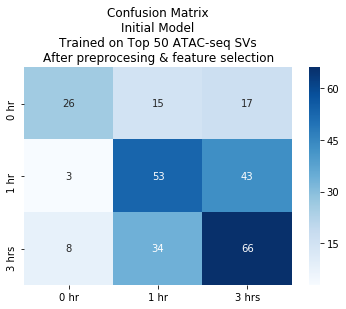

In [301]:
make_confusion_matrix_DEX(Y_atac_test, y_atac_pred, subtitle='Initial Model\nTrained on Top 50 ATAC-seq SVs\nAfter preprocesing & feature selection')

In [302]:
''' Evaluate model trained ONLY on RNA-seq input '''
y_rna_pred = predict_one_hot(X_rna_test, model_dir='models/best_rna_pca_model_pp_fs')
y_rna_sm = predict(X_rna_test, model_dir='models/best_rna_pca_model_pp_fs')

In [303]:
''' Get metrics for RNA-seq'''
print(f'Accuracy: {accuracy(Y_rna_test, y_rna_pred)}')
print(f'Precision: {precision(Y_rna_test, y_rna_pred)}')
print(f'Recall: {precision(Y_rna_test, y_rna_pred)}')

Accuracy: 0.9371069073677063
Precision: 0.9056603908538818
Recall: 0.9056603908538818


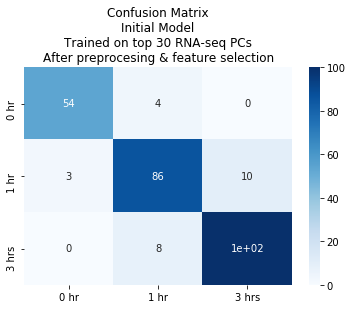

In [304]:
make_confusion_matrix_DEX(Y_rna_test, y_rna_pred, subtitle='Initial Model\nTrained on top 30 RNA-seq PCs\nAfter preprocesing & feature selection')

In [305]:
''' Evaluate model trained on bimodal input (concatenation of ATAC + RNA) '''
y_bimodal_pred = predict_one_hot(X_bimodal_test, model_dir='models/best_bimodal_pca_svd_model_pp_fs')
y_bimodal_sm = predict(X_bimodal_test, model_dir='models/best_bimodal_pca_svd_model_pp_fs')

In [306]:
''' Get metrics using bimodal input '''
print(f'Accuracy: {accuracy(Y_bimodal_test, y_bimodal_pred)}')
print(f'Precision: {precision(Y_bimodal_test, y_bimodal_pred)}')
print(f'Recall: {precision(Y_bimodal_test, y_bimodal_pred)}')

Accuracy: 0.952201247215271
Precision: 0.9283018708229065
Recall: 0.9283018708229065


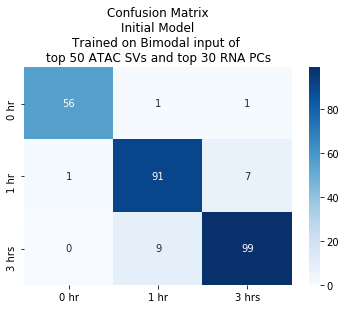

In [307]:
make_confusion_matrix_DEX(Y_bimodal_test, y_bimodal_pred, subtitle='Initial Model\nTrained on Bimodal input of \ntop 50 ATAC SVs and top 30 RNA PCs')

In [308]:
''' Evaluate model trained on bimodal input (concatenation of ATAC + RNA) '''
y_bi_low_pred = predict_one_hot(X_bi_low_test, model_dir='models/best_factor2_model_pp_fs')
y_bi_low_sm = predict(X_bi_low_test, model_dir='models/best_factor2_model_pp_fs')

In [309]:
X_bi_low_train.shape

TensorShape([2376, 2])

In [310]:
''' Get metrics using bimodal input '''
print(f'Accuracy: {accuracy(Y_bi_low_test, y_bi_low_pred)}')
print(f'Precision: {precision(Y_bi_low_test, y_bi_low_pred)}')
print(f'Recall: {precision(Y_bi_low_test, y_bi_low_pred)}')

Accuracy: 0.605031430721283
Precision: 0.4075471758842468
Recall: 0.4075471758842468


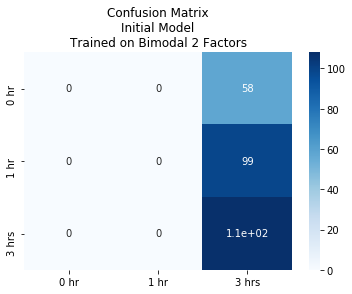

In [311]:
make_confusion_matrix_DEX(Y_bi_low_test, y_bi_low_pred, subtitle='Initial Model\nTrained on Bimodal 2 Factors')

In [312]:
''' Export training and test sets '''
from helpers import *

# create .pkl file names
root = os.getcwd()
pkl_path = os.path.join(root, 'data', 'sci-CAR', 'pkl_files')
pkl_atac = os.path.join(pkl_path, 'atac_pp_svd_fs_.pkl')
pkl_rna = os.path.join(pkl_path, 'rna_pp_fs_pca_.pkl')
pkl_bimodal = os.path.join(pkl_path, 'bimodal_pca_svd_pp_fs.pkl')
pkl_bi_low = os.path.join(pkl_path, 'bimodal_factor2_pp_fs.pkl')

# save training and test sets as pickle files
atac_data = (X_atac_train, X_atac_test, atac_features)
write_zipped_pickle(atac_data, pkl_atac)
print('atac data saved')

rna_data = (X_rna_train, X_rna_test, rna_features)
write_zipped_pickle(rna_data, pkl_rna)
print('rna data saved')

bimodal_data = (X_bimodal_train, X_bimodal_test, bimodal_features)
write_zipped_pickle(bimodal_data, pkl_bimodal)
print('bimodal data saved')

bi_low_data = (X_bi_low_train, X_bi_low_test, bi_low_features)
write_zipped_pickle(bi_low_data, pkl_bi_low)
print('bi_low data saved')

atac data saved
rna data saved
bimodal data saved
bi_low data saved








Training Epochs: 100%|██████████| 100/100 [00:39<00:00, 29.21it/s]







Training Epochs: 100%|██████████| 100/100 [00:24<00:00, 32.65it/s]